In [183]:
import numpy as np
import pandas as pd
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sea

from astropy.cosmology import Planck13 as cosmo
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_exam import Gen_spec

import fsps
from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate


import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# plot Ha

In [189]:
alldb = pd.read_pickle('../dataframes/fitdb/allfitsdb.pkl')

In [184]:
sfdb = pd.read_pickle('../Casey_data/SF_db_p1.pkl')

In [195]:
sflines = pd.merge(alldb, sfdb, on=['id'], how='inner')


In [216]:
sflines.Hb

0    -9.900000e+01
1    -9.900000e+01
2     3.189737e-17
3     3.890400e-17
4    -9.900000e+01
5    -9.900000e+01
6    -9.900000e+01
7     9.946470e-18
8    -9.900000e+01
9    -9.900000e+01
10   -9.900000e+01
11   -9.900000e+01
12   -9.900000e+01
13    8.282301e-17
14    3.933572e-17
15    3.984798e-17
16    4.452417e-17
17    1.112916e-17
18    2.446469e-17
19   -9.900000e+01
20   -9.900000e+01
21    5.673086e-17
22    2.344186e-17
23    1.596996e-16
24   -9.900000e+01
25   -9.900000e+01
26    2.299335e-17
27   -9.900000e+01
28   -9.900000e+01
29   -9.900000e+01
          ...     
39   -9.900000e+01
40   -9.900000e+01
41   -9.900000e+01
42   -9.900000e+01
43   -9.900000e+01
44   -9.900000e+01
45   -9.900000e+01
46   -9.900000e+01
47    4.605988e-17
48   -9.900000e+01
49   -9.900000e+01
50   -9.900000e+01
51   -9.900000e+01
52    4.309138e-17
53    5.805858e-17
54   -9.900000e+01
55    1.156841e-16
56   -9.900000e+01
57   -9.900000e+01
58   -9.900000e+01
59   -9.900000e+01
60   -9.9000

In [230]:
sfHA = sflines.query('OII > 0')

field = sfHA.field_x.values
gid = sfHA.id.values


GND_lines = [GN1l, GN2l,GN3l,GN4l, GN5l, GN7l]
GSD_lines = [GS1l, GS2l,GS3l,GS4l, GS5l, ERSPRIMEl]

Ha_g_fluxes = []
Ha_g_err = []
z50_g = []
zer_g = []

for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values
            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values

            if len(FLUX) > 0:
                Ha_g_fluxes.append(FLUX[0])
                Ha_g_err.append(ERR[0])
                
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                
                break
                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values
            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                Ha_g_fluxes.append(FLUX[0])
                Ha_g_err.append(ERR[0])
                
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break

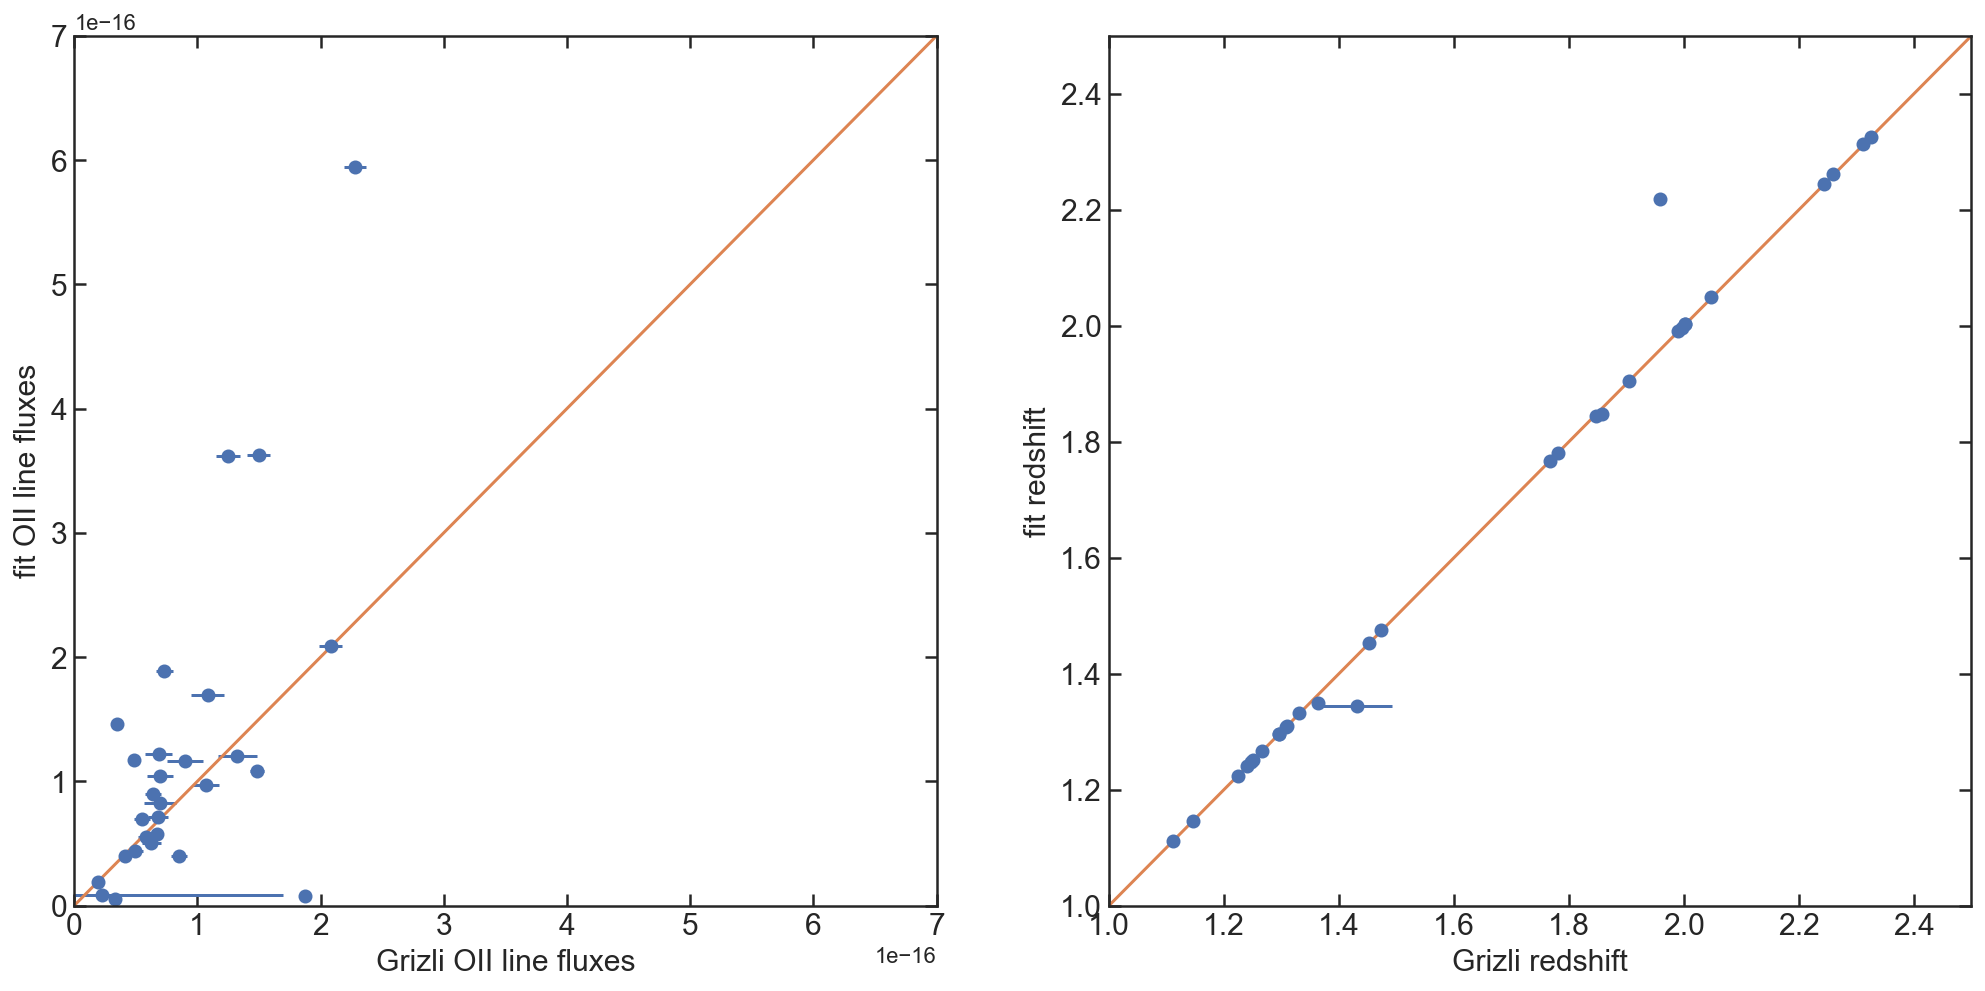

In [236]:
gs = gridspec.GridSpec(1,2)

Hal = [sfHA.OII[U] - sfHA.OII_hci[U][0] for U in sfHA.index]
Hah = [sfHA.OII_hci[U][1] - sfHA.OII[U] for U in sfHA.index]

zl = [sfHA.zgrism_x[U] - sfHA.zgrism_hci[U][0] for U in sfHA.index]
zh = [sfHA.zgrism_hci[U][1] - sfHA.zgrism_x[U] for U in sfHA.index]

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(Ha_g_fluxes, sfHA.OII.values ,xerr = Ha_g_err, yerr=[Hal, Hah] ,linestyle = 'none', marker = 'o')
plt.plot([0,1.1E-15],[0,1.1E-15])
plt.xlim(0,0.7E-15)
plt.ylim(0,0.7E-15)

plt.ylabel('fit OII line fluxes', fontsize=15)
plt.xlabel('Grizli OII line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, sfHA.zgrism_x, xerr = zer_g, yerr=[zl,zh] ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(1.,2.5)
plt.ylim(1.,2.5)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/OII_sfcompare.png', bbox_inches = 'tight')

# all galaxies

In [89]:
fls = glob('../data/linefits/*Ha*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

zfl = []
for i in range(len(field)):
    zfl.append(glob('../data/posteriors/{}_{}*Mfit_Pz.npy'.format(field[i], gid[i]))[0])

In [198]:
GN1l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN1_lines_grizli.fits'), format = 'fits').to_pandas()
GN2l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN2_lines_grizli.fits'), format = 'fits').to_pandas()
GN3l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN3_lines_grizli.fits'), format = 'fits').to_pandas()
GN4l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN4_lines_grizli.fits'), format = 'fits').to_pandas()
GN5l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN5_lines_grizli.fits'), format = 'fits').to_pandas()
GN7l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GN7_lines_grizli.fits'), format = 'fits').to_pandas()

GS1l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS1_lines_grizli.fits'), format = 'fits').to_pandas()
GS2l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS2_lines_grizli.fits'), format = 'fits').to_pandas()
GS3l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS3_lines_grizli.fits'), format = 'fits').to_pandas()
GS4l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS4_lines_grizli.fits'), format = 'fits').to_pandas()
GS5l = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/GS5_lines_grizli.fits'), format = 'fits').to_pandas()
ERSPRIMEl = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/ERSPRIME_lines_grizli.fits'), format = 'fits').to_pandas()

In [83]:
# z_50	z_02	z_16	z_84z_50	z_02	z_16	z_84

In [91]:
GND_lines = [GN1l, GN2l,GN3l,GN4l, GN5l, GN7l]
GSD_lines = [GS1l, GS2l,GS3l,GS4l, GS5l, ERSPRIMEl]

Ha_g_fluxes = []
Ha_g_err = []
z50_g = []
zer_g = []

for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).Ha_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).Ha_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values
            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values

            if len(FLUX) > 0:
                Ha_g_fluxes.append(FLUX[0])
                Ha_g_err.append(ERR[0])
                
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                
                break
                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).Ha_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).Ha_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values
            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                Ha_g_fluxes.append(FLUX[0])
                Ha_g_err.append(ERR[0])
                
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break
                
Ha_v_fluxes = []
Ha_v_err = []               
for f in fls:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    Ha_v_fluxes.append(m)
    Ha_v_err.append((hci[1] - hci[0]) / 2)    

z_v= []
zerr_v = []               
for f in zfl:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    z_v.append(m)
    zerr_v.append((hci[1] - hci[0]) / 2)  

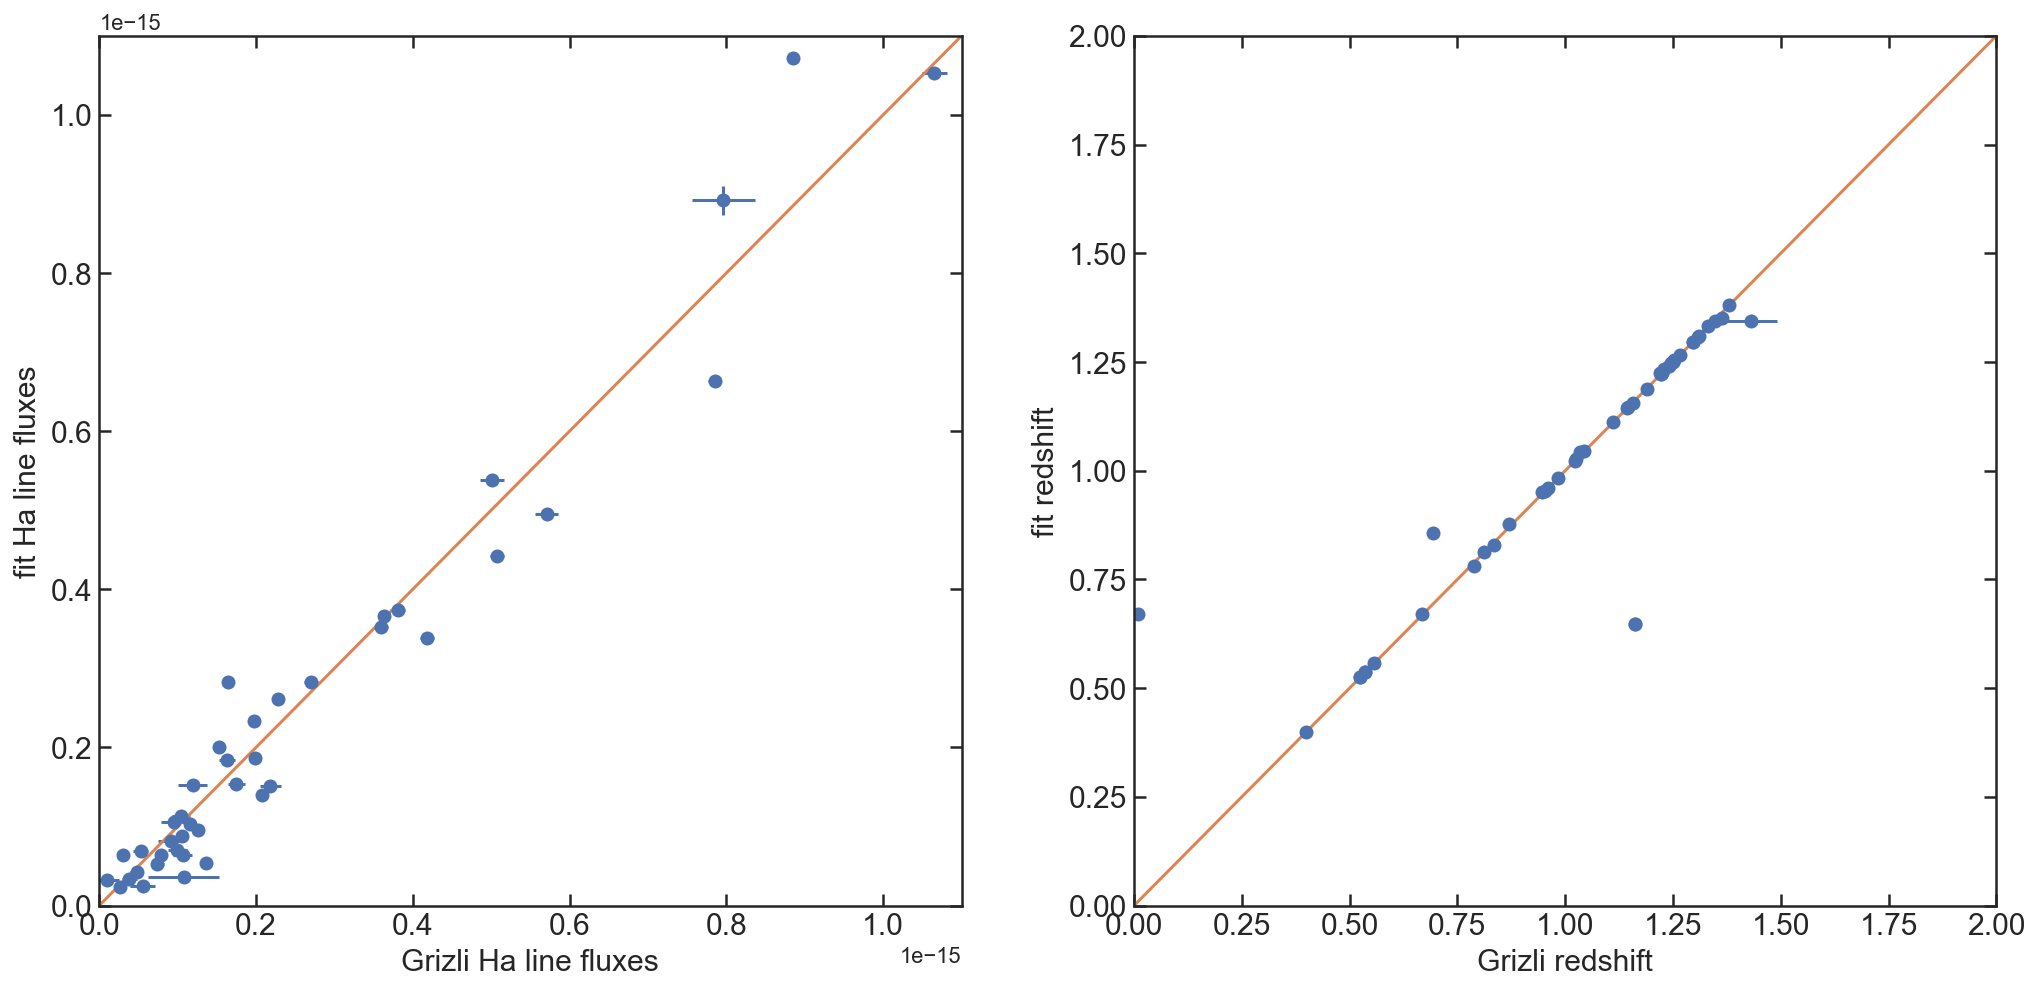

In [96]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(Ha_g_fluxes, Ha_v_fluxes,xerr = Ha_g_err, yerr=Ha_v_err ,linestyle = 'none', marker = 'o')
plt.plot([0,1.1E-15],[0,1.1E-15])
plt.xlim(0,1.1E-15)
plt.ylim(0,1.1E-15)

plt.ylabel('fit Ha line fluxes', fontsize=15)
plt.xlabel('Grizli Ha line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, z_v, xerr = zer_g, yerr=zerr_v ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(0,2)
plt.ylim(0,2)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/Ha_compare.png', bbox_inches = 'tight')

# Plot Hb

In [97]:
fls = glob('../data/linefits/*Hb*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

zfl = []
for i in range(len(field)):
    zfl.append(glob('../data/posteriors/{}_{}*Mfit_Pz.npy'.format(field[i], gid[i]))[0])

In [101]:
Hb_g_fluxes = []
Hb_g_err = []
z50_g = []
zer_g = []

for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).Hb_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).Hb_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                Hb_g_fluxes.append(FLUX[0])
                Hb_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).Hb_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).Hb_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                Hb_g_fluxes.append(FLUX[0])
                Hb_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                
Hb_v_fluxes = []
Hb_v_err = []               
for f in fls:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    Hb_v_fluxes.append(m)
    Hb_v_err.append((hci[1] - hci[0]) / 2)  
    
z_v= []
zerr_v = []               
for f in zfl:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    z_v.append(m)
    zerr_v.append((hci[1] - hci[0]) / 2)  

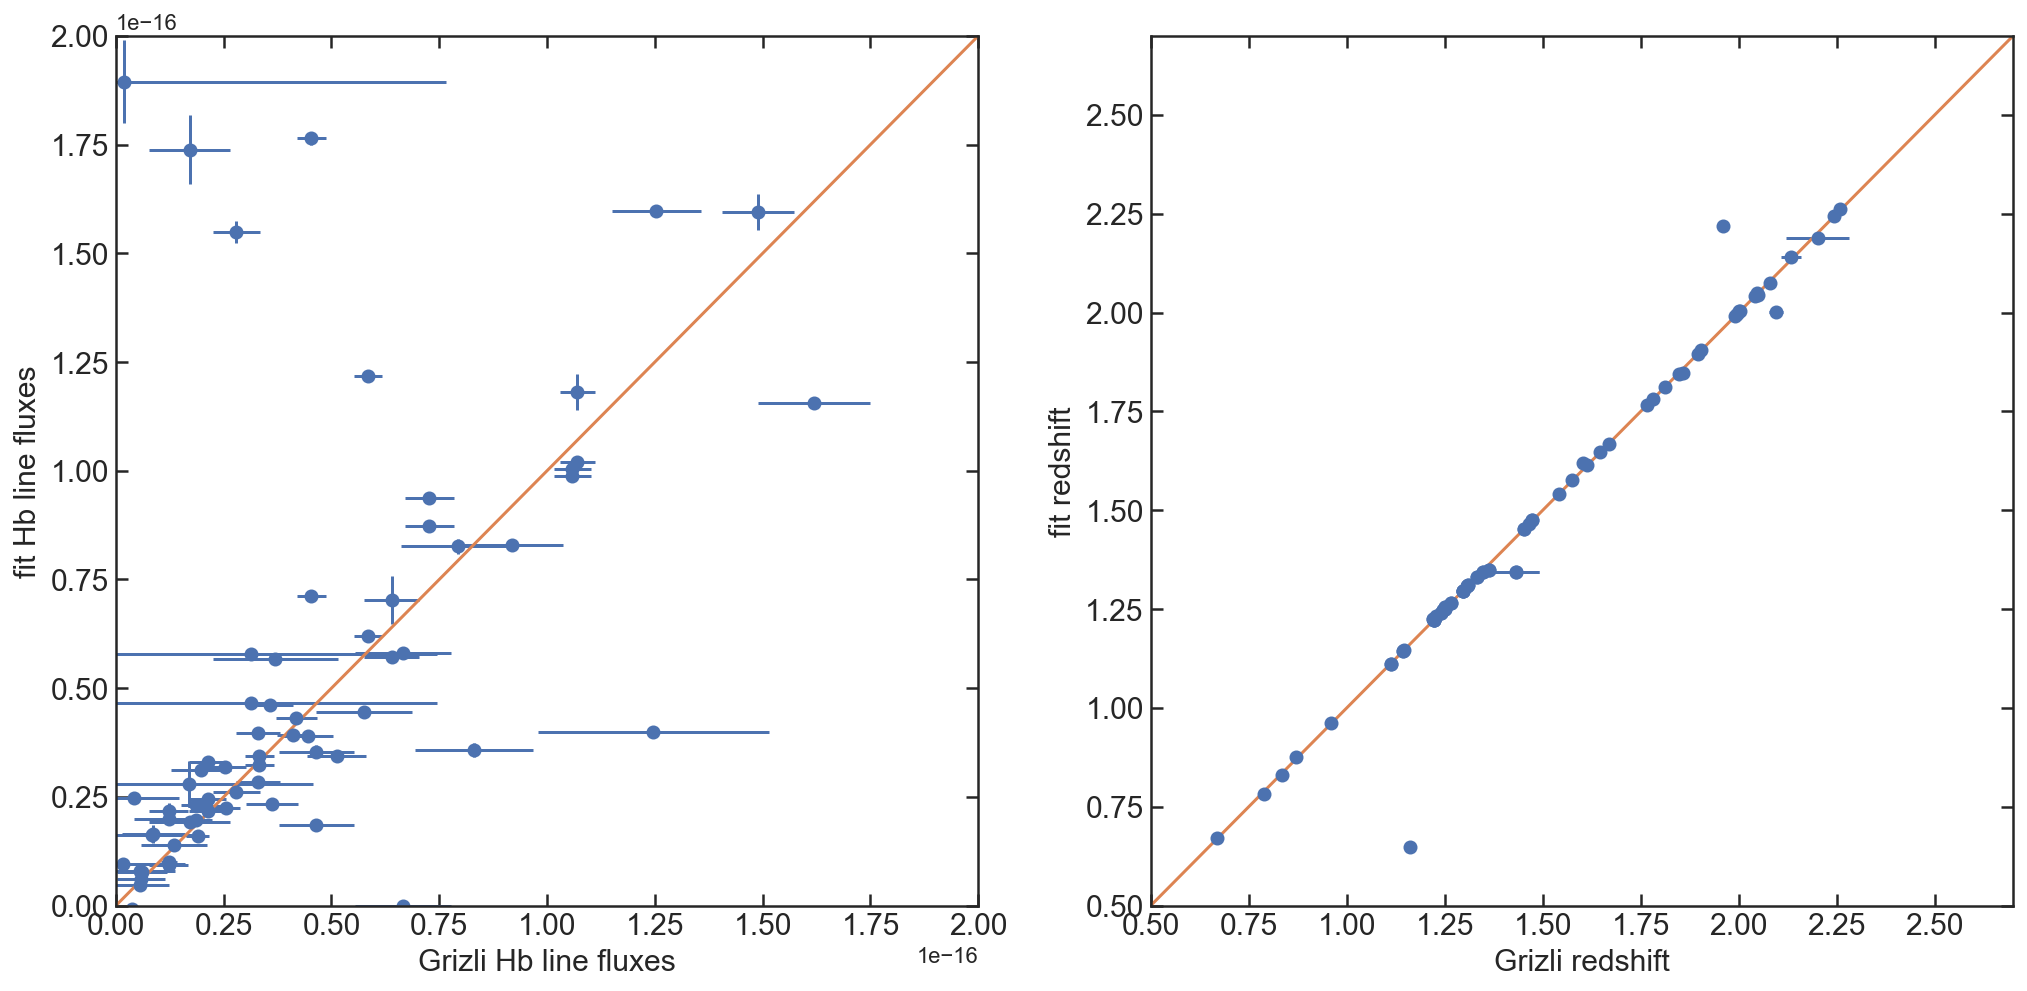

In [104]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(Hb_g_fluxes, Hb_v_fluxes,xerr = Hb_g_err, yerr=Hb_v_err ,linestyle = 'none', marker = 'o')
plt.plot([0,1.1E-15],[0,1.1E-15])
plt.xlim(0,2E-16)
plt.ylim(0,2E-16)


plt.ylabel('fit Hb line fluxes', fontsize=15)
plt.xlabel('Grizli Hb line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, z_v, xerr = zer_g, yerr=zerr_v ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(0.5,2.7)
plt.ylim(0.5,2.7)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('../plots/Hb_compare.png', bbox_inches = 'tight')

# Plot OIII

In [105]:
fls = glob('../data/linefits/*OIII_*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

zfl = []
for i in range(len(field)):
    zfl.append(glob('../data/posteriors/{}_{}*Mfit_Pz.npy'.format(field[i], gid[i]))[0])

In [106]:
OIII_g_fluxes = []
OIII_g_err = []
z50_g = []
zer_g = []
for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OIII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OIII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                OIII_g_fluxes.append(FLUX[0])
                OIII_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OIII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OIII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                OIII_g_fluxes.append(FLUX[0])
                OIII_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                
OIII_v_fluxes = []
OIII_v_err = []               
for f in fls:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    OIII_v_fluxes.append(m)
    OIII_v_err.append((hci[1] - hci[0]) / 2)  
    
z_v= []
zerr_v = []               
for f in zfl:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    z_v.append(m)
    zerr_v.append((hci[1] - hci[0]) / 2)  

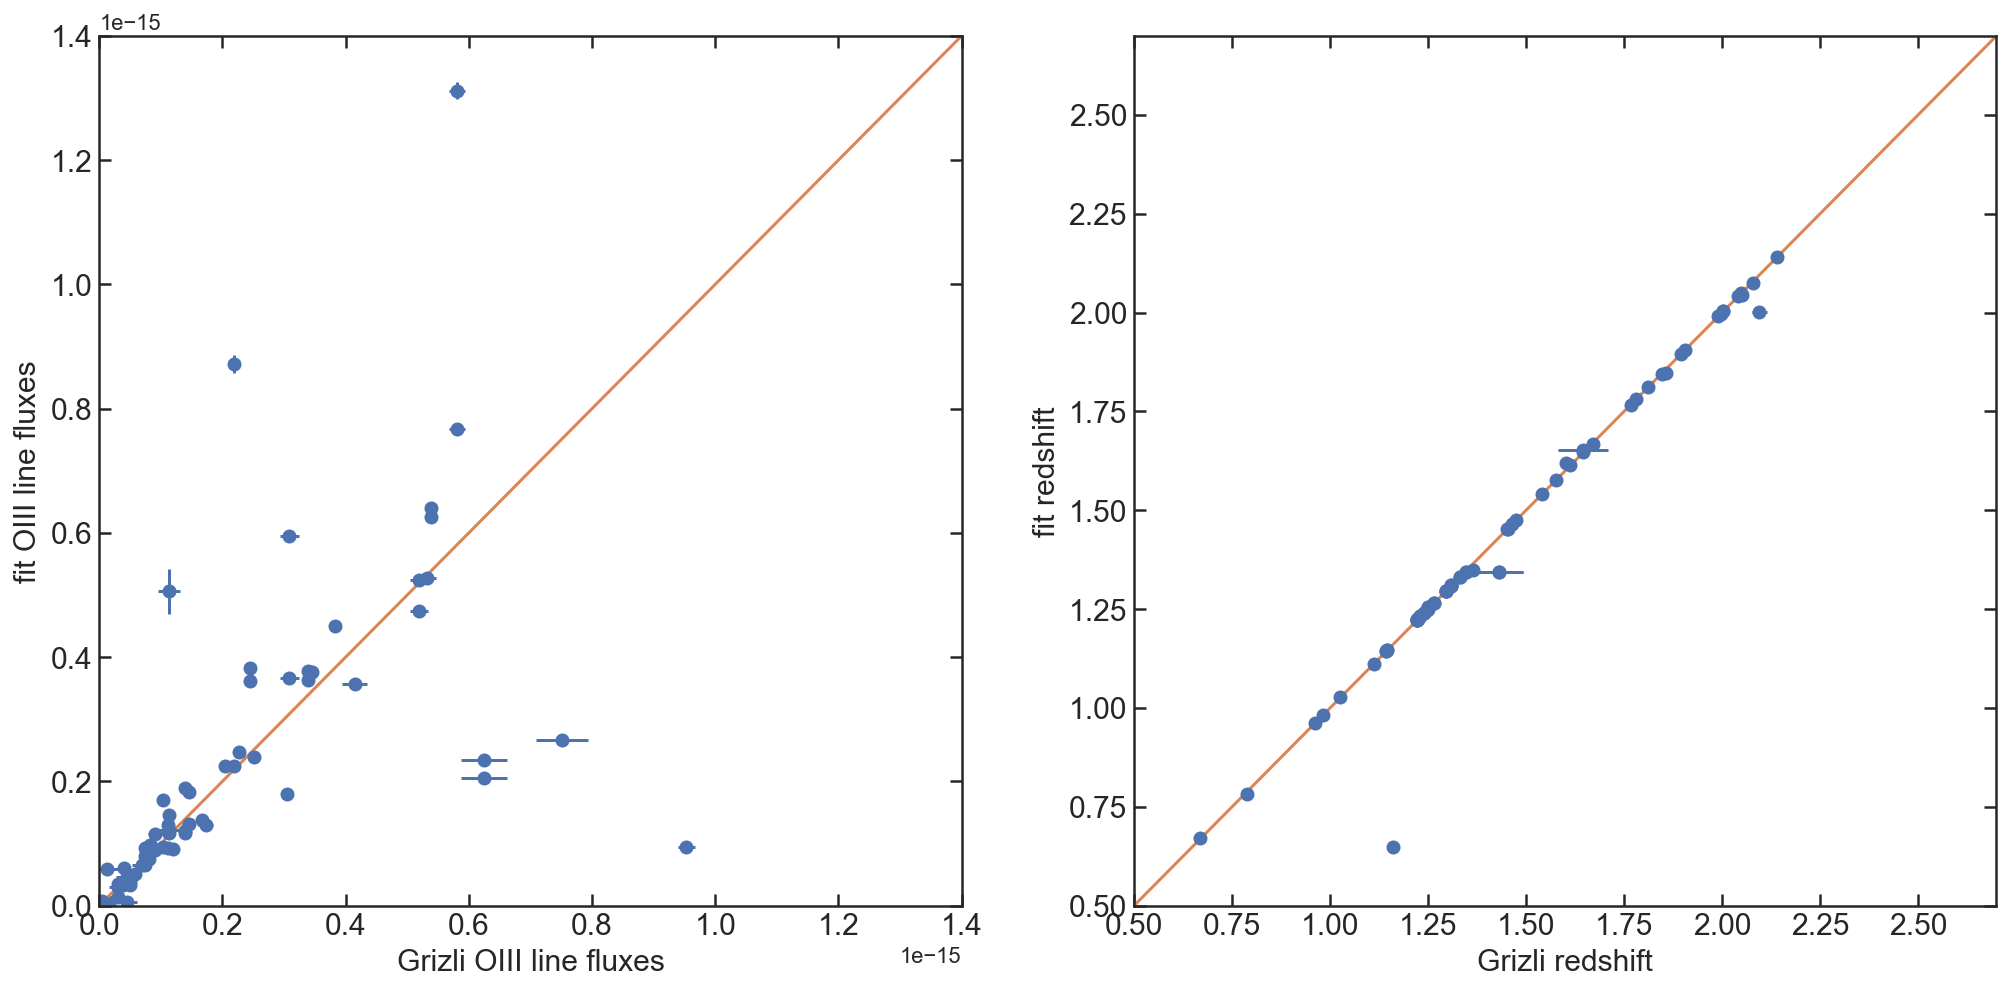

In [108]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(OIII_g_fluxes, OIII_v_fluxes,xerr = OIII_g_err, yerr=OIII_v_err ,linestyle = 'none', marker = 'o')
plt.plot([0,1.5E-15],[0,1.5E-15])
plt.xlim(0,1.4E-15)
plt.ylim(0,1.4E-15)


plt.ylabel('fit OIII line fluxes', fontsize=15)
plt.xlabel('Grizli OIII line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, z_v, xerr = zer_g, yerr=zerr_v ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(0.5,2.7)
plt.ylim(0.5,2.7)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/OIII_compare.png', bbox_inches = 'tight')

# Plot OII

In [109]:
fls = glob('../data/linefits/*OII_*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

zfl = []
for i in range(len(field)):
    zfl.append(glob('../data/posteriors/{}_{}*Mfit_Pz.npy'.format(field[i], gid[i]))[0])

In [110]:
OII_g_fluxes = []
OII_g_err = []
z50_g = []
zer_g = []
for i in range(len(field)):
    if field[i][1] == 'N':
        for F in GND_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values
   
            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                OII_g_fluxes.append(FLUX[0])
                OII_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                

    if field[i][1] == 'S':
        for F in GSD_lines:
            FLUX = F.query('ID == {}'.format(gid[i])).OII_FLUX.values * 1E-17
            ERR = F.query('ID == {}'.format(gid[i])).OII_FLUX_ERR.values * 1E-17
            RS = F.query('ID == {}'.format(gid[i])).z_50.values

            RSERRH = F.query('ID == {}'.format(gid[i])).z_84.values
            RSERRL = F.query('ID == {}'.format(gid[i])).z_16.values
            if len(FLUX) > 0:
                OII_g_fluxes.append(FLUX[0])
                OII_g_err.append(ERR[0])
                z50_g.append(RS[0])
                zer_g.append((RSERRH[0] - RSERRL[0]) / 2)
                break                
OII_v_fluxes = []
OII_v_err = []               
for f in fls:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    OII_v_fluxes.append(m)
    OII_v_err.append((hci[1] - hci[0]) / 2)  
    
z_v= []
zerr_v = []               
for f in zfl:
    x,px = np.load(f)
    m, hci, mod = Highest_density_region(px,x)
    z_v.append(m)
    zerr_v.append((hci[1] - hci[0]) / 2)  

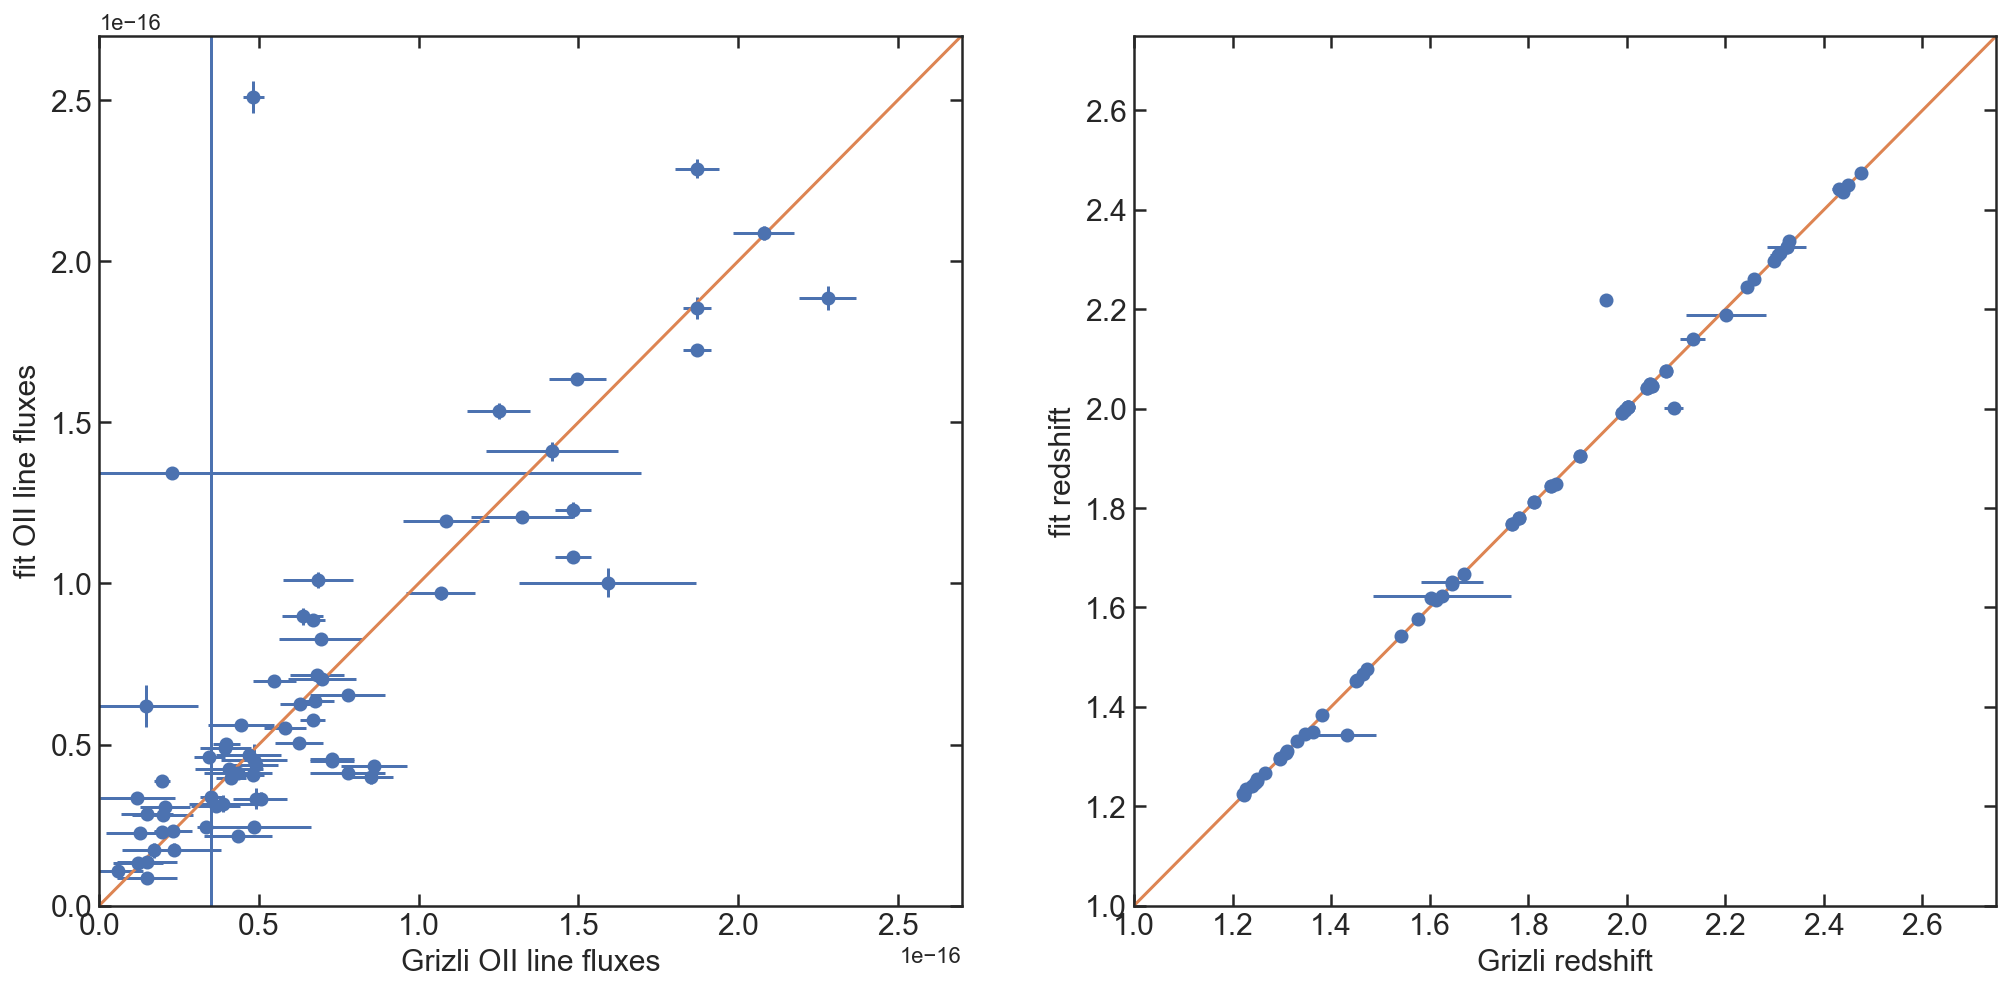

In [113]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[17,8])
plt.subplot(gs[0])
plt.errorbar(np.array(OII_g_fluxes), np.array(OII_v_fluxes),
             xerr = np.array(OII_g_err), yerr=np.array(OII_v_err),linestyle = 'none', marker = 'o')
plt.plot([0,1.5E-15],[0,1.5E-15])
plt.xlim(0,0.27E-15)
plt.ylim(0,0.27E-15)


plt.ylabel('fit OII line fluxes', fontsize=15)
plt.xlabel('Grizli OII line fluxes', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(gs[1])
plt.errorbar(z50_g, z_v, xerr = zer_g, yerr=zerr_v ,linestyle = 'none', marker = 'o')
plt.plot([0,4],[0,4])
plt.xlim(1,2.75)
plt.ylim(1,2.75)

plt.ylabel('fit redshift', fontsize=15)
plt.xlabel('Grizli redshift', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('../plots/OII_compare.png', bbox_inches = 'tight')

# stack line posteriors

In [40]:
fls = glob('../data/linefits/*Ha*')

field = [os.path.basename(U).split('_')[0] for U in fls]
gid = [os.path.basename(U).split('_')[1] for U in fls]

gal_set = []
for i in range(len(field)):
    if gid[i] in gal_set:
        print(field[i],gid[i])
    gal_set.append(gid[i])

GSD 41755
GND 36596
GSD 36482


In [41]:
fls

['../data/linefits/GND_11279_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GND_36596_tabMfit_Pline Ha_0.npy',
 '../data/linefits/GSD_40192_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GSD_41755_SFMfit_Pline Ha_0.npy',
 '../data/linefits/GND_36433_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GND_32719_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GSD_41755_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GSD_40108_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GND_36596_tabMfit_Pline Ha_1.npy',
 '../data/linefits/GND_37893_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GND_11460_SFMfit_Pline Ha_0.npy',
 '../data/linefits/GND_21156_tabMfit_Pline Ha_1.npy',
 '../data/linefits/GSD_48652_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GSD_24062_SFMfit_Pline Ha_0.npy',
 '../data/linefits/GSD_23421_tabMfit_Pline Ha_1.npy',
 '../data/linefits/GND_32108_tabMfit_Pline Ha_1.npy',
 '../data/linefits/GSD_20651_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GND_10639_SFMfit_Pline Ha_1.npy',
 '../data/linefits/GND_23302_SFMfit_Pline

In [ ]:
mb = multifit.MultiBeam('../beams/ERSPRIME_39170.beams.fits', **args)

In [38]:
### function to build
### auto remove bad pdf
### id by redshift
### filter out too high and too low 
### if both good combine

Bwv = mb.oned_spectrum()['G102']['wave']
Bft = mb.oned_spectrum()['G102']['flat']

Rwv = mb.oned_spectrum()['G141']['wave']
Rft = mb.oned_spectrum()['G141']['flat']

iBft = interp1d(Bwv, Bft/ max(Bft), bounds_error=False, fill_value=0)
iRft = interp1d(Rwv, Rft/ max(Rft), bounds_error=False, fill_value=0)

def line_post_comb(fls, zfl, line):
    x,px = np.load(fls[0])
    y,py = np.load(fls[1])

    mx, hdrx, modx = Highest_density_region(px,x)
    my, hdry, mody = Highest_density_region(py,y)
    
    ###select mode
    lowlim = 1E-20
    hilim = 1E-14
    
    MODE = 'none'
    
    if (not lowlim < mx < hilim) | (not lowlim < my < hilim):
        MODE = 'filter'
    
    if MODE == 'none' and np.log10(np.abs(mx - my)/mx) > 1:
        MODE = 'autoselect'
        
    if MODE == 'none':
        MODE = 'combine'

    ###filter
    if MODE == 'filter':
        if lowlim < mx < hilim:
            return x,px
        
        if lowlim < my < hilim:
            return y,py
        
    ###autoselect by z
    if MODE == 'autoselect':
        z,pz = np.load(zfl)
        mz, hdrz, modz = Highest_density_region(pz,z)

        ln_nm = []
        ln_wv = []
        for k in args['t1']:
            if k[0] == 'l':
                ln_wv.append(np.round(args['t1'][k].wave[args['t1'][k].flux == max(args['t1'][k].flux)][0]))
                ln_nm.append(k[5:])
                
        Bllim = 7700
        Bhlim = 11300
        
        Rllim = 11300
        Rhlim = 16500
        
        LW = ln_wv[ln_nm == line]
        
        OLW = LW * (1+mz)
        
        if Bllim <= OLW <= Bhlim:
            return x,px

        if Rllim <= OLW <= Rhlim:
            return y,py 
                     
    ###combine
    if MODE == 'combine':
        z,pz = np.load(zfl)
        mz, hdrz, modz = Highest_density_region(pz,z)

        ln_nm = []
        ln_wv = []
        for k in args['t1']:
            if k[0] == 'l':
                ln_wv.append(np.round(args['t1'][k].wave[args['t1'][k].flux == max(args['t1'][k].flux)][0]))
                ln_nm.append(k[5:])
        
        LW = ln_wv[ln_nm == line]
        
        OLW = LW * (1+mz)

        allmin = [min(x),min(y)]
        allmax = [max(x),max(y)]

        X = np.linspace(min(allmin), max(allmax),1000)
        ipx = interp1d(x,px,bounds_error=False, fill_value=True)(X)
        ipy = interp1d(y,py,bounds_error=False, fill_value=True)(X)


        PX = ipx*iBft(OLW) + iRft(OLW) * ipy
        
        return X, PX / np.trapz(PX,X)

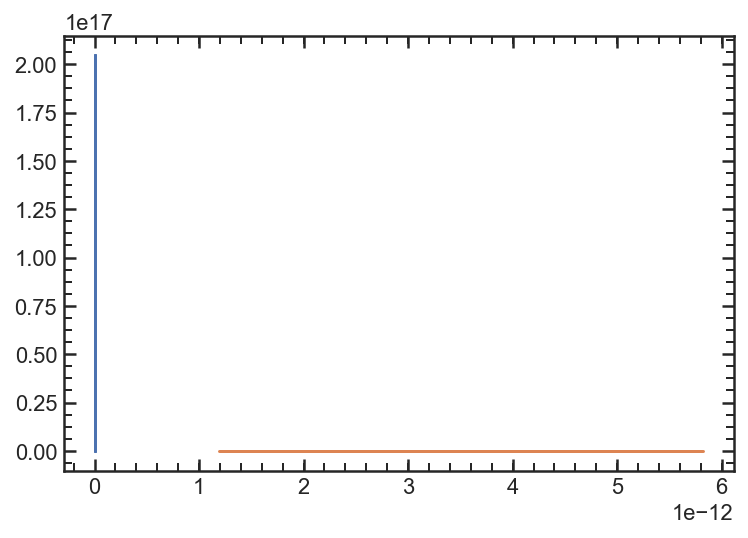

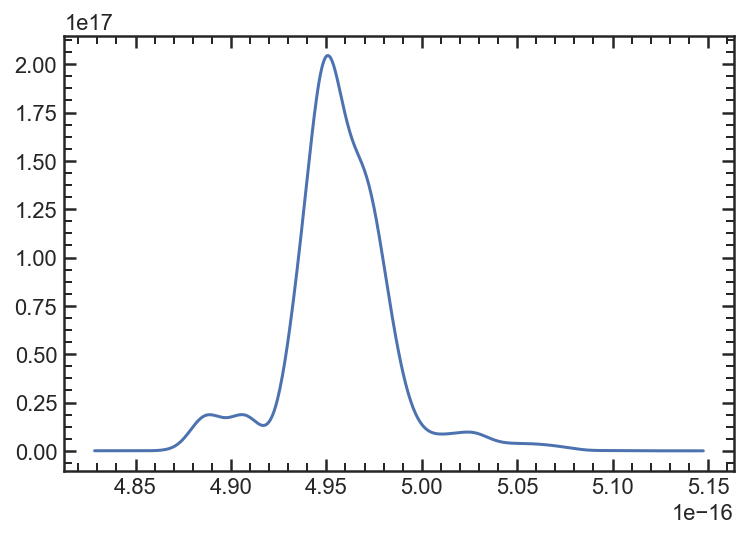

In [46]:
x,px = np.load('../data/linefits/GND_36596_tabMfit_Pline Ha_0.npy')
y,py = np.load('../data/linefits/GND_36596_tabMfit_Pline Ha_1.npy')
X,PX = line_post_comb(glob('../data/linefits/GND_36596_*_Pline Ha*.npy'), '../data/posteriors/GND_36596_tabfit_Pz.npy', 'Ha')

plt.figure()
plt.plot(x,px)
plt.plot(y,py)

plt.figure()
plt.plot(X,PX)

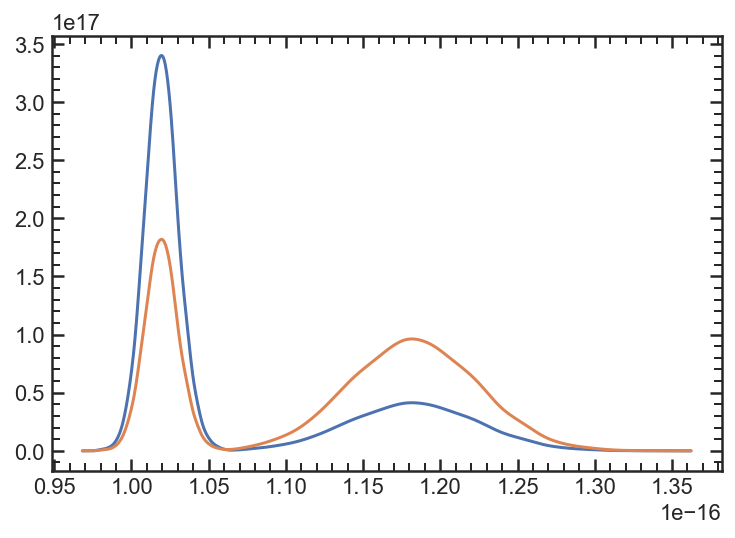

In [36]:
allmin = [min(x),min(y)]
allmax = [max(x),max(y)]

X = np.linspace(min(allmin), max(allmax),1000)
ipx = interp1d(x,px,bounds_error=False, fill_value=True)(X)
ipy = interp1d(y,py,bounds_error=False, fill_value=True)(X)


plt.plot(X, ipx*iBft(11220) + iRft(11220) * ipy)


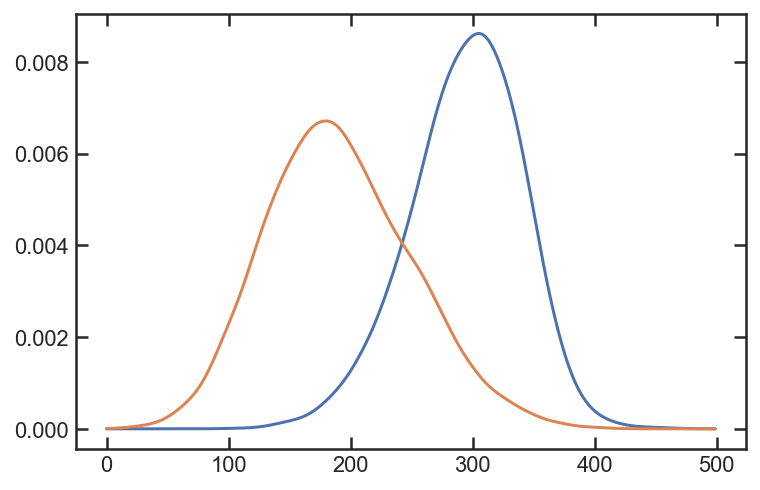

In [182]:
plt.plot(np.arange(500), px/np.trapz(px,np.arange(500)))
plt.plot(np.arange(500), py/np.trapz(py,np.arange(500)))

In [150]:
(not 1E-20 < 5.230565527677531e-30 < 1E-14) | (not 1E-20 < 5.805858287347268e-17 < 1E-14)

True

In [169]:
ln_nm = []
ln_wv = []
for k in args['t1']:
    if k[0] == 'l':
        ln_wv.append(np.round(args['t1'][k].wave[args['t1'][k].flux == max(args['t1'][k].flux)][0]))
        ln_nm.append(k[5:])
        

In [170]:
ln_nm

['PaB',
 'HeI-1083',
 'SIII',
 'OII-7325',
 'ArIII-7138',
 'SII',
 'Ha',
 'OI-6302',
 'HeI-5877',
 'OIII',
 'Hb',
 'OIII-4363',
 'Hg',
 'Hd',
 'H7',
 'H8',
 'H9',
 'H10',
 'NeIII-3867',
 'OII',
 'NeVI-3426',
 'NeV-3346',
 'MgII',
 'CIV-1549',
 'CIII-1908',
 'OIII-1663',
 'HeII-1640',
 'NIII-1750',
 'NIV-1487',
 'NV-1240',
 'Lya']

In [13]:
mb = multifit.MultiBeam('../beams/ERSPRIME_39170.beams.fits', **args)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ibhj23sxq_flt.fits G141
22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [20]:
Bwv = mb.oned_spectrum()['G102']['wave']
Bft = mb.oned_spectrum()['G102']['flat']

Rwv = mb.oned_spectrum()['G141']['wave']
Rft = mb.oned_spectrum()['G141']['flat']

iBft = interp1d(Bwv, Bft/ max(Bft), bounds_error=False, fill_value=0)
iRft = interp1d(Rwv, Rft/ max(Rft), bounds_error=False, fill_value=0)


plt.plot(Bwv, Bft/ max(Bft))
plt.plot(Rwv, Rft/ max(Rft))
plt.axvline(11220)

In [34]:
iBft(11220),iRft(11220)

(array(0.93479553), array(0.42983187))

# Examen Stellar pop fits

In [22]:
all1d = pd.read_pickle('../dataframes/fitdb/all_1d_fits.pkl')
all2d = pd.read_pickle('../dataframes/fitdb/allfitsdb.pkl')
mdb = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

In [7]:
all1d= all1d.sort_values('id')
all2d= all2d.sort_values('id')

In [29]:
m2d = pd.merge(all2d, mdb, on=['id'], how='inner')
mdb= mdb.sort_values('id')
m2d= m2d.sort_values('id')

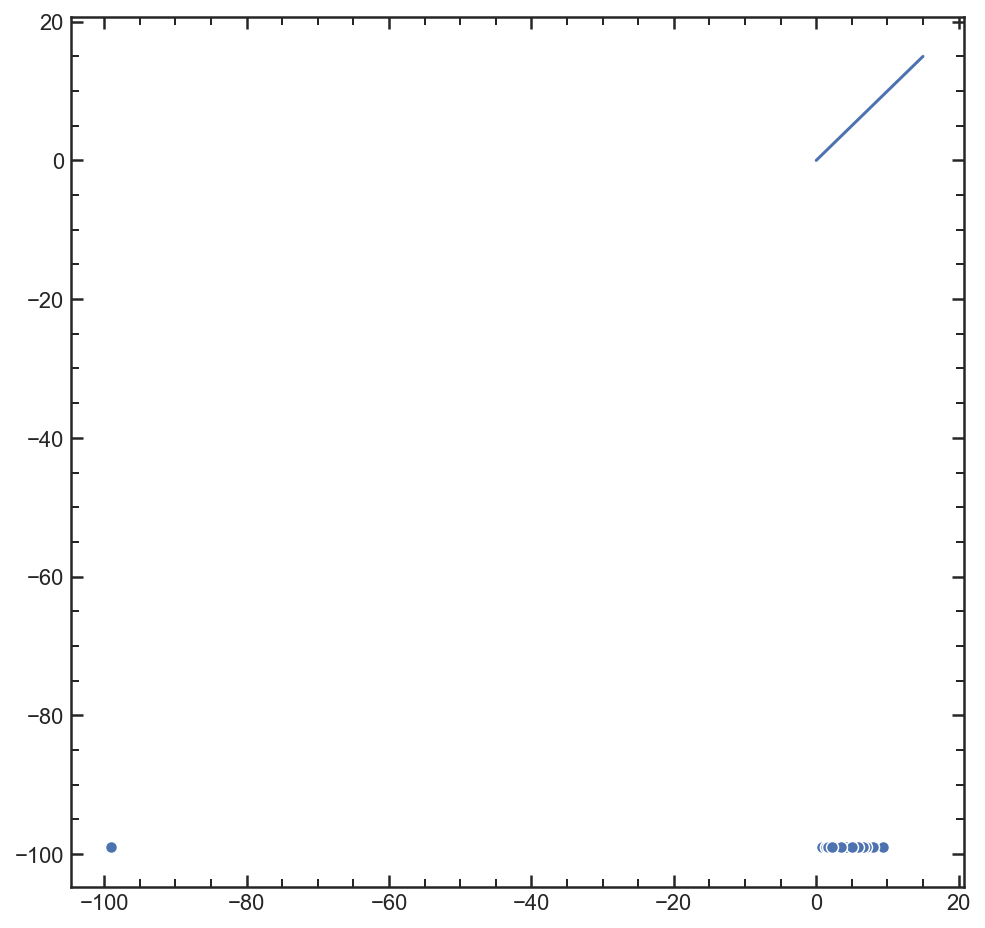

In [20]:
plt.figure(figsize = [8,8])
sea.scatterplot(all1d.z_50.values, all2d.z_50.values)
# plt.xlim(0,4)
# plt.ylim(0,4)
plt.plot([0,15],[0,15])

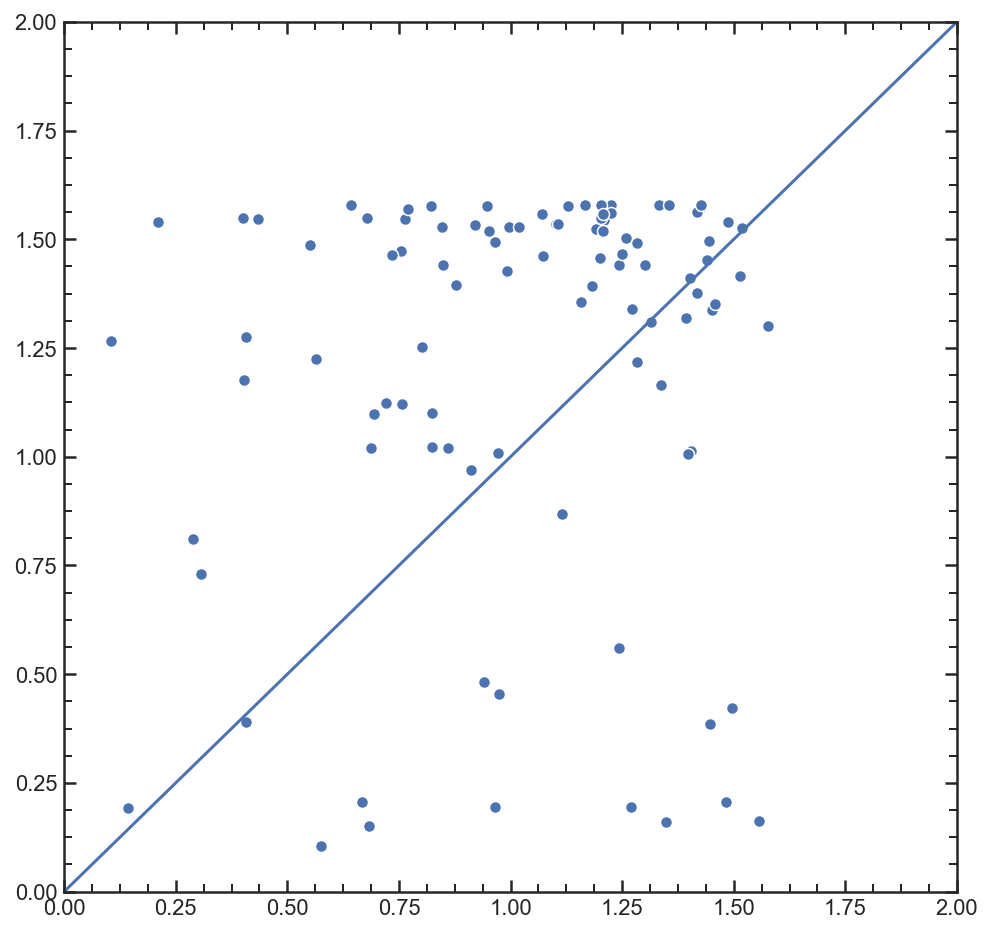

In [50]:
plt.figure(figsize = [8,8])
sea.scatterplot(mdb.query('lmass > 10.5').Z.values, m2d.query('lmass_y > 10.5').Z_x.values)
plt.xlim(0,2)
plt.ylim(0,2)
plt.plot([0,15],[0,15])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


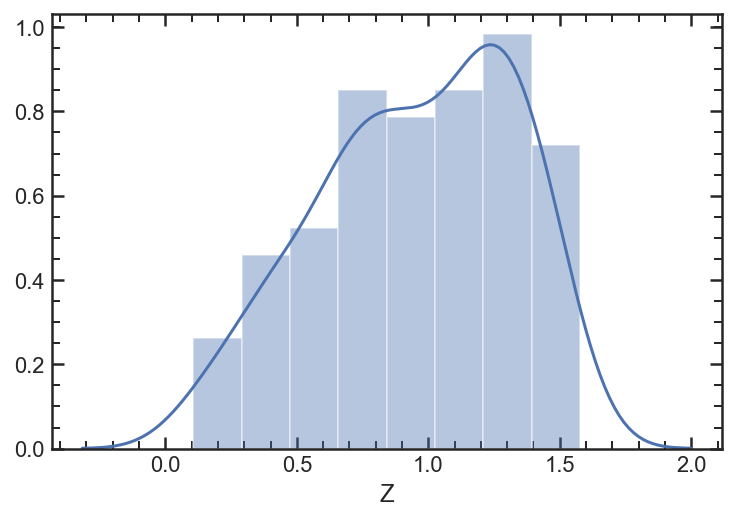

In [40]:
sea.distplot(mdb.Z)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 2)

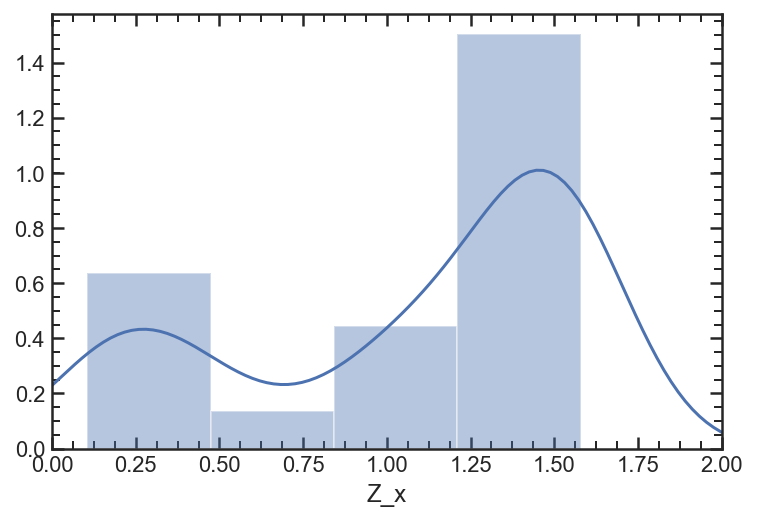

In [43]:
sea.distplot(m2d.query('Z_x > 0').Z_x)
plt.xlim(0,2)